This notebook preprocessed raw trisonica data to adjust the reference system to the EP one 

In [ ]:
from pathlib import Path
import numpy as np
from multiprocessing import Pool
import logging as log
from functools import partial
from wind_tools import *
from scipy.spatial.transform import Rotation as R
from copy import deepcopy
log.basicConfig(level=log.INFO) #uncomment to see messages from extract
# name_re = r"*_TRS_M00506_com3.raw"
u, v, w = 0, 1, 2 #defing costants for accessing data

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,10)

In [ ]:
# in_dir = Path("2020_data/data_20200724_final_field_install/raw")
# out_dir = Path("2020_data/data_20200724_final_field_install/preprocessed")

In [ ]:
in_dir = Path("2020_data/data_field_v2_from_20208010/raw")
out_dir = Path("2020_data/data_field_v2_from_20208010/preprocessed")

## Filtered wind directions

In [ ]:
start_angle = 230
range_angle = 30
wm_basename = '_WM_174605_com1.raw'
wm_offset = 310

def wm_dir_filter(f):
    """f is the filename of another anemometer at the same time"""
    wm_path = f.parent / (f.name[:13] + wm_basename) # the first 13 is the date info
    wm = np.genfromtxt(wm_path, usecols=(2,3), invalid_raise=False, delimiter=',')
    wd = mod(get_wind_dir(wm[:, 0], wm[:, 1]) + wm_offset)
    return filter_by_wind_dir_single(wd, start_angle, range_angle) 

def get_filtered_proc(filt):
    def _inner(data):
        new_data = data
        length = min(len(data), len(filt))
        new_data[:length][~filt[:length ]] = -9999
        return new_data
    return _inner

def extract_filtered(setting, f):
    
    filt = wm_dir_filter(f)
    old_processor = deepcopy(getordef(setting, 'processor'))
    def my_proc(data):
        data = old_processor(data)
        return get_filtered_proc(filt)(data)
    setting['processor'] = my_proc
    extract(setting,f)


### General funcs

In [ ]:
def extract(setting, f):
    usecols, delimiter, name_suffix, transform, replace = map(partial(getordef, setting), ['usecols', 'delimiter', 'name_suffix', 'transform', 'replace'])
    # log.info(f"opening {f}")
    out_name = out_dir / f"{f.name[:-4]}{name_suffix}.csv"
    if not replace and out_name.exists():
        log.debug(f" exists, skipping {out_name}")
    else:
        data = np.genfromtxt(f, usecols=usecols, invalid_raise=False, delimiter=delimiter)
        data = transform(setting, data)
        np.savetxt(out_name, data, header="u,v,w,t", delimiter=',', fmt='%2.2f', comments='')
        log.info(f"saved file {out_name}")

def nothing(setting, x):
    return x

def getordef(setg, item):
    if item in setg:
        return setg[item]
    elif item in settings_default:
        return settings_default[item]
    else:
        raise KeyError("Key not found in default settings")

In [ ]:
def rotate(setting, data):
    rot = getordef(setting, 'rotation')
    rot_data = data.copy() #to preserve temperature
    rot_data[:, [0,1,2]] = rot.apply(data[:, [0,1,2]])
    
    return rot_data

In [ ]:
def main():
    print("starting processing...")
    if not out_dir.is_dir(): out_dir.mkdir(parents=True, exist_ok=True)
    with Pool() as p:
        for key in settings:
            print(f"processing {key}")
            proc = partial(getordef(settings[key], 'extractor'), settings[key])
            p.map(proc, in_dir.glob(getordef(settings[key], "name_re")))
    print("done")
    # for f in in_dir.glob(name_re):
    #     extract(f)

## Settings

settings for each anemometer, the processor take in input an array where columns are u,v,w,t and returns a transformed array

In [ ]:
settings_default = {
        
        'extractor': extract, # Function that extracts from the text file the data array and saves it to the disk
        'usecols': None, # columns that should be considered by extract function
        'delimiter': None, #delimi tween column in the input file
    
        'transform': nothing, # function to tranform the data before saving like rotating or filtering. signature is process(setting, data) -> transformed data
        'rotation': None, # scipy rotation for the rotate function      
    
        'name_suffix': '', #suffix that is appened on the file name before saving
        'replace': True, # if should replace exiting file with same name        
    }

In [ ]:
rot_m507 = R.from_euler('XYZ', [90, -250,  135], degrees=True) # 250 can be +/- 10 °

rot_m506 = R.from_euler('z', [-90.], degrees=True)
rot_wm1 = R.from_euler('z', [50], degrees=True) # why here 50 and there -90 bohhh but who cares basta che va


wm_cols = (2,3, 4, 6)
trs_cols = (10, 12, 14, 16)

settings = {
    'm506': {
        'usecols': trs_cols,
        'name_re': r"*_TRS_M00506_com3.raw",
        'transform': rotate,
        'rotation': rot_m506,
        },
    'm507': {
        'usecols': trs_cols,
        'name_re': r"*_TRS_M00507_com2.raw",
        'transform': rotate,
        'rotation': rot_m507
    },
    'm506_raw': {
        'usecols': trs_cols,
        'name_re': r"*_TRS_M00506_com3.raw",
        'name_suffix': "_raw",
        'transform': nothing,
        },
    'wm1':{
        'usecols': wm_cols,
        'name_re': r"*_WM_174605_com1.raw",
        'delimiter': ',',
        'transform': rotate,
        'rotation': rot_wm1,        
    }

#     'm507_raw': { #Does nothing but allow to use EP to aggregate data
#         'usecols': (10, 12, 14, 16),
#         'name_re': r"*_TRS_M00507_com2.raw",
#         'processor': nothing,
#         'name_suffix': '_raw'
#     },
#     'm507_filtered':{
#         'usecols': (10, 12, 14, 16),
#         'name_re': r"*_TRS_M00507_com2.raw",
#         'extractor': extract_filtered,
#         'processor': process_m507,
#         'name_suffix': '_filtered_230_30',
#     },
#     'wm1_filtered':{
#         'usecols': (2,3, 4, 5),
#         'name_re': r"*_WM_174605_com1.raw",
#         'extractor': extract_filtered,
#         'name_suffix': '_filtered_230_30',
#         'delimiter': ','
#     }
}

In [ ]:
main()

starting processing...
processing m506


INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-2300_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0630_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0530_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0730_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-1830_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0930_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0830_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1900_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0400_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_field_v2_f

processing m507


INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-1730_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-2230_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0230_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0830_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1030_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0430_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1706_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0500_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1600_TRS_M00507_com2.csv
INFO:root:saved file 2020_data/data_field_v2_f

processing m506_raw


INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1900_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0730_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0530_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0400_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-2100_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0000_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0630_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-2300_TRS_M00506_com3_raw.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0930_TRS_M00506_com3_raw.csv
INFO:root:

processing wm1


INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1430_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200812-0230_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1600_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-1630_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-1600_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-0430_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-1830_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200811-2000_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208010/preprocessed/20200810-1500_WM_174605_com1.csv
INFO:root:saved file 2020_data/data_field_v2_from_20208

done


In [ ]:
rot_m506.apply(np.array([[1,2,3]]))

array([[ 2., -1.,  3.]])

# Tests and Explanations

In [ ]:
def vecs3d_legend(name="", colors=['r', 'g', 'b', 'fuchsia', 'yellow', 'cyan'], labels=['u', 'v', 'w', 'u reference system', 'v reference system', 'w reference system']):
    handles = []
    for col, label in zip(colors, labels):
        handles.append(mpatches.Patch(color=col, label=label))
    
    plt.legend(handles=handles)

###  M506

In [ ]:
rot_m506 = R.from_euler('z', [-90.], degrees=True)
def process_m506(data):
    # fix TRS1 u and v ax by inverting it, due to different coordinate system between trisonica and EP
    rot_data = data.copy() #to preserve temperature
    rot_data[:, [u,v,w]] = rot_m506.apply(data[:, [u,v,w]])
    return data

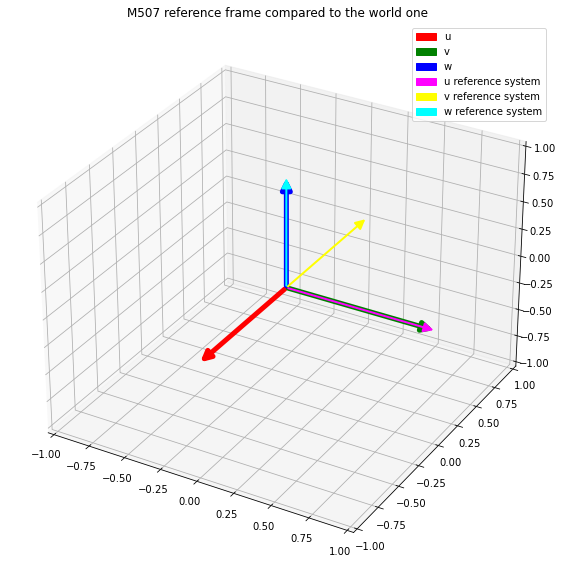

In [ ]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.set_title("M507 reference frame compared to the world one ")
plot_vecs3d(rot_m506.apply(v0), colors=['r', 'g', 'b'], ax=ax, lw=5 )
plot_vecs3d(v0, colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one

vecs3d_legend()

#### Tests

In [ ]:
v1 = [1,2,3]

In [ ]:
test_close(rot_m506.apply(v1),[ 2., -1.,  3.] )

### M507

In [ ]:
rot_m507 = R.from_euler('XYZ', [90, 0,  135], degrees=True) 

def process_m507(data):      
    rot_data = data.copy() #to preserve temperature
    rot_data[:, [u,v,w]] = rot_m507.apply(data[:, [u,v,w]])
    
    return rot_data


In [ ]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.set_title("M507 reference frame compared to the world one ")
plot_vecs3d(rot_m507.apply(v0), colors=['r', 'g', 'b'], ax=ax, lw=5 )
plot_vecs3d(v0, colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one

vecs3d_legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Those tests works only no rotation on the y** TODO fix this

In [ ]:
v2 = [1,1,2],

In [ ]:
rot_m507.apply(v2)

array([[1.41421356e+00, 2.00000000e+00, 3.33066907e-16]])

In [ ]:
test_close(rot_m507.apply(v2), [-np.sqrt(2), -2., 0.])

In [ ]:
v3 = [0,1,3]

In [ ]:
test_close(rot_m507.apply(v3), [-np.sin(np.pi/4),-3,-np.sin(np.pi/4)])

## Testing M507 wind filter

In [ ]:
#interesting period with EP data is
testf = in_dir / "20200724-2200_WM_174605_com1.raw"
tfilt = wm_dir_filter(testf)

In [ ]:
tfilt[:1210]

array([False, False, False, ..., False, False, False])

In [ ]:
ep_outf = in_dir / "../processed/eddypro_raw_datasets/level_1/20200724-2202_raw_dataset_2020-08-07T163138_adv.txt"

In [ ]:
ep_out = np.genfromtxt(ep_outf, skip_header=10)

In [ ]:
ep_out[ep_out==-9999.] = np.nan

In [ ]:
ep_out[181]

array([nan, nan, nan, nan])

In [ ]:
wd = mod(get_wind_dir(ep_out[:, 0], ep_out[:, 1]) + wm_offset)

In [ ]:
wdr = get_wind_dir(ep_out[:, 0], ep_out[:, 1])

In [ ]:
wdr[~np.isnan(wdr)].mean()

19.65297272650223

In [ ]:
wd[~np.isnan(wd)].mean()

329.65297272650224